# Testing DEMV on _German Credit_ dataset

- Positive label: credit=1
- Protected group: age=0, sex=0

In [9]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity, GridSearch

import seaborn as sns

from utils import *
from demv import DEMV
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [10]:
data = pd.read_csv('data2/german.csv', index_col=0)

In [11]:
data

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [12]:
label = 'credit'
positive_label = 1
sensitive_features = ['sex', 'age']
unpriv_group = {'sex': 0, 'age': 0}

In [13]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased data

In [14]:
model, bias_metrics = cross_val(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [15]:
print_metrics(bias_metrics)

Statistical parity:  -0.201  +-  0.139
Disparate impact:  0.743  +-  0.164
Zero one loss:  0.317  +-  0.117
F1 score:  0.731  +-  0.045
Accuracy score:  0.741  +-  0.044


## DEMV

In [16]:
demv_data = data.copy()
demv = DEMV(round_level=1)

In [17]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [18]:
print_metrics(demv_metrics)

Statistical parity:  -0.128  +-  0.155
Disparate impact:  0.807  +-  0.159
Zero one loss:  0.257  +-  0.13
F1 score:  0.739  +-  0.04
Accuracy score:  0.75  +-  0.037


## DEMV evaluation

In [19]:
metrics = eval_demv(2, demv.get_iters(), data.copy(), pipeline, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [20]:
df = prepareplots(metrics,'german')

##  Blackbox Postprocessing

In [21]:
model, blackboxmetrics, pred = cross_valbin(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.6296 0.8226
   1.0 0.6000 0.8333

And loss is 0.3200


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.5217 0.8070
   1.0 0.5556 0.7273

And loss is 0.3100


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.5862 0.9091
   1.0 0.3333 0.8000

And loss is 0.2600


Pre-adjustment group rates are 

 group   fpr    tpr
   0.0 0.625 0.8750
   1.0 0.375 0.4167

And loss is 0.2800


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.6087 0.9138
   1.0 0.6667 0.7143

And loss is 0.2900


Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.5 0.9394
   1.0  0.4 0.7273

And loss is 0.1800


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.4583 0.9091
   1.0 0.5000 0.8182

And loss is 0.2300


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.5833 0.9259
   1.0 0.4286 0.5333

And loss is 0.2800


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.5

##  Plot

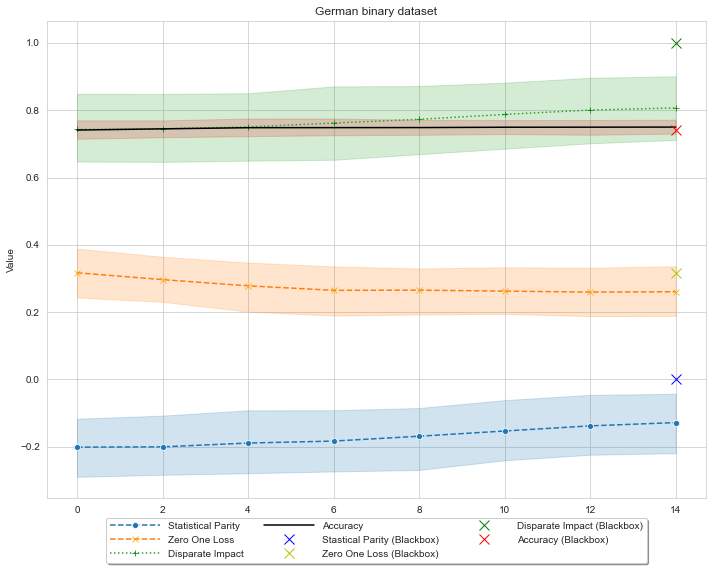

In [22]:
points = preparepoints(blackboxmetrics,demv.get_iters())

plot_metrics_curves(df, points, 'German binary dataset')

In [24]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 1000
Unprivileged group size: 105
Percentage of unprivileged group: 10.5
Number of iterations: 14


In [25]:
save_metrics('blackbox', 'german', blackboxmetrics)